In [1]:
from utils import *
import fastbook
fastbook.setup_book()
#hide
from fastbook import *
from fastai.tabular.all import *


In [2]:
path= Path('./space_ship_titanic')

In [3]:
path.ls()

(#6) [Path('space_ship_titanic/train.csv'),Path('space_ship_titanic/sample_submission.csv'),Path('space_ship_titanic/Untitled.ipynb'),Path('space_ship_titanic/submission.csv'),Path('space_ship_titanic/.ipynb_checkpoints'),Path('space_ship_titanic/test.csv')]

In [4]:
df = pd.read_csv(path/'train.csv')

In [5]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
cat_names = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
cont_names = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
y_names = ['Transported']
procs = [Categorify, Normalize, FillMissing]
y_block = CategoryBlock()

In [7]:
tp = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, y_block=y_block)

In [8]:
dls = tp.dataloaders()

In [9]:
dls.show_batch()

,HomePlanet,CryoSleep,Destination,VIP,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Earth,False,TRAPPIST-1e,False,False,False,False,False,False,False,12.999999,27.000004,80.999992,1080.000014,-0.000011,0.000005,True
1,Earth,False,TRAPPIST-1e,False,False,False,False,False,False,False,16.000000,0.000001,19.999994,0.000004,300.000000,680.999997,False
2,Earth,False,TRAPPIST-1e,False,False,False,False,False,False,False,15.000000,0.000001,400.000000,0.000004,-0.000011,702.000003,False
3,Earth,False,TRAPPIST-1e,False,False,False,False,False,False,False,6.000001,0.000001,0.000017,0.000004,-0.000011,0.000005,True
4,Earth,False,TRAPPIST-1e,False,False,False,False,False,False,False,24.000000,381.000005,925.000013,342.000004,-0.000011,642.000005,False
5,Earth,False,TRAPPIST-1e,False,False,False,False,False,False,False,43.000000,0.000001,8.999988,1145.000025,-0.000011,0.000005,False
6,Mars,False,TRAPPIST-1e,False,False,False,False,False,False,False,51.000001,1671.000032,0.000017,17.000002,-0.000011,0.000005,False
7,Earth,False,55 Cancri e,False,False,False,False,False,False,False,10.000000,0.000001,0.000017,0.000004,-0.000011,0.000005,True
8,Earth,False,TRAPPIST-1e,False,False,False,False,False,False,False,18.000000,0.000001,287.999997,34.999996,-0.000011,435.000004,False
9,Earth,False,55 Cancri e,False,False,False,False,False,False,False,14.000000,713.999983,237.000000,0.000004,586.999996,1.000000,False


In [10]:
emb_szs = get_emb_sz(dls); emb_szs

[(4, 3),
 (3, 3),
 (4, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3)]

In [11]:
tp.fill_strategy

'median'

In [12]:
norms = tp.procs.normalize
cont_col_stat = pd.DataFrame([norms.means, norms.stds], index = ["mean","std"])
cont_col_stat

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
mean,28.790291,220.009323,448.434021,169.572296,304.588867,298.261810
std,14.340584,660.472717,1595.655151,597.972046,1125.505615,1134.088623


In [13]:
learn = tabular_learner(dls, metrics=accuracy)

In [14]:
learn.summary()

TabularModel (Input shape: 64 x 10)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 3              
Embedding                                 12         True      
Embedding                                 9          True      
Embedding                                 12         True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Embedding                                 9          True      
Dropout                                                        
BatchNorm1d                               12         True      
____________________________________________________________________________
             

SuggestedLRs(valley=0.0010000000474974513)

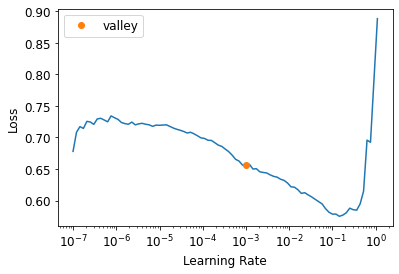

In [15]:
learn.lr_find()

In [16]:
learn.fit(20, lr=0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.468148,None,None,00:01
1,0.452867,None,None,00:01
2,0.449284,None,None,00:01
3,0.441050,None,None,00:01
4,0.444348,None,None,00:01
5,0.449123,None,None,00:01
6,0.439544,None,None,00:01
7,0.439127,None,None,00:01
8,0.449810,None,None,00:01
9,0.434480,None,None,00:01


/home/jupyter/.local/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [17]:
t_df = pd.read_csv(path/'test.csv')

In [18]:
t = learn.dls.train_ds.new(t_df)
t.process()

dl = TabDataLoader(t)
preds = learn.get_preds(dl=dl)[0].argmax(1).numpy()
preds[:5]

array([1, 0, 1, 1, 0])

In [19]:
subm = pd.read_csv(path/'sample_submission.csv')
sub = pd.DataFrame({'PassengerId':subm.PassengerId, 'Transported': preds.astype(bool)})
sub.to_csv(path/'submission.csv', index=False)